# Fesmaro 2025 Analisis Big Data

## Proyek Analisis Sentimen: Topic Modeling dengan LDA dan LSA

**Tujuan:** Notebook ini bertujuan untuk menerapkan dan mengevaluasi metode Latent Dirichlet Allocation (LDA) dan Latent Semantic Analysis (LSA) pada dataset teks ulasan sebagai bagian dari proyek analisis sentimen. Tujuannya adalah untuk mengidentifikasi topik-topik laten dalam ulasan dan mengeksplorasi bagaimana fitur topik ini dapat digunakan lebih lanjut.

## SETUP

In [1]:
# Import library dasar
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import time # Untuk mengukur waktu eksekusi

# Import library NLTK untuk pemrosesan teks
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Import library Gensim untuk LSA dan LDA
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel, TfidfModel, CoherenceModel, LdaMulticore

# Import library untuk visualisasi LDA
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Import gdown untuk download data dari Google Drive
import gdown

# Konfigurasi tampilan
%matplotlib inline
pd.set_option('display.max_colwidth', 200) # Tampilkan lebih banyak teks di kolom pandas
warnings.filterwarnings('ignore', category=DeprecationWarning) # Abaikan warning Deprecation
pyLDAvis.enable_notebook() # Aktifkan visualisasi pyLDAvis di notebook

# Download NLTK data (jika belum ada)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    print("Mengunduh NLTK 'punkt'...")
    nltk.download('punkt', quiet=True)
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    print("Mengunduh NLTK 'stopwords'...")
    nltk.download('stopwords', quiet=True)

print("Setup selesai. Library dan data NLTK siap digunakan.")

Setup selesai. Library dan data NLTK siap digunakan.


## DATA LOADING & INITIAL EXPLORATION

In [2]:
print("\n" + "="*60)
print("1. MEMUAT DAN MENGEKSPLORASI DATA")
print("="*60)

# --- Unduh Data dari Google Drive ---
# Pastikan folder 'data' ada atau buat jika belum
output_folder = '/kaggle/working/data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder '{output_folder}' dibuat.")

# URL folder Google Drive (pastikan link ini benar dan dapat diakses)
drive_folder_url = "https://drive.google.com/drive/u/4/folders/1La029vITSdOyDC-TaKZ9kxVk0twOneFv"
print(f"Mengunduh data dari Google Drive folder: {drive_folder_url}")
try:
    downloaded_files = gdown.download_folder(drive_folder_url, output=output_folder, quiet=True, use_cookies=False)
    print(f"File yang berhasil diunduh: {downloaded_files}")
    if not downloaded_files:
        raise ValueError("Tidak ada file yang diunduh. Periksa URL dan hak akses Google Drive.")
except Exception as e:
    print(f"\nError saat mengunduh data: {e}")
    print("Pastikan URL folder Google Drive benar dan folder/file dapat diakses (sharing settings).")
    # Anda mungkin perlu menangani error ini lebih lanjut, misalnya dengan menghentikan eksekusi
    # exit()

# --- Muat Data dari CSV ---
data_path = os.path.join(output_folder, "final_df.csv")
print(f"\nMemuat data dari: {data_path}")
try:
    df = pd.read_csv(data_path)
    print(f"Data berhasil dimuat. Jumlah baris: {len(df)}, Jumlah kolom: {len(df.columns)}")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di '{data_path}'. Pastikan file CSV ada di folder 'data'.")
    # exit() # Hentikan eksekusi jika file tidak ditemukan

# --- Eksplorasi Awal ---
print("\n--- Informasi Data ---")
df.info()

print("\n--- 5 Baris Pertama Data ---")
print(df.head())

print("\n--- Statistik Deskriptif (Fitur Numerik) ---")
# Hanya tampilkan statistik untuk kolom numerik yang relevan untuk analisis awal
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print(df[numeric_cols].describe())

print("\n--- Cek Missing Values ---")
print(df.isnull().sum())
# Jika ada missing values di 'lemmatized_text', perlu penanganan (misal, diisi string kosong atau dihapus)
if df['lemmatized_text'].isnull().any():
    print("\nWarning: Terdapat missing values di kolom 'lemmatized_text'. Mengisinya dengan string kosong.")
    df['lemmatized_text'].fillna('', inplace=True)


1. MEMUAT DAN MENGEKSPLORASI DATA
Mengunduh data dari Google Drive folder: https://drive.google.com/drive/u/4/folders/1La029vITSdOyDC-TaKZ9kxVk0twOneFv
File yang berhasil diunduh: ['/kaggle/working/data\\df_processed.csv', '/kaggle/working/data\\df_test.csv', '/kaggle/working/data\\df_train.csv', '/kaggle/working/data\\df_val.csv', '/kaggle/working/data\\final_df.csv']

Memuat data dari: /kaggle/working/data\final_df.csv
Data berhasil dimuat. Jumlah baris: 100000, Jumlah kolom: 11

--- Informasi Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   label                 100000 non-null  int64  
 1   lemmatized_text       100000 non-null  object 
 2   text_length           100000 non-null  int64  
 3   word_count            100000 non-null  int64  
 4   avg_word_length       100000 non-null  float64
 5   exclamatio

## TEXT PREPROCESSING

In [3]:
print("\n" + "="*60)
print("2. PREPROCESSING TEKS")
print("="*60)

# --- Definisikan Stopwords ---
# Menggunakan stopwords bahasa Inggris dari NLTK
stop_words = set(stopwords.words('english'))
# Tambahkan custom stopwords jika perlu (misalnya, kata yang sangat umum di domain Anda tapi tidak informatif)
custom_stopwords = {'number', 'also', 'get', 'use', 'make', 'one'} # Contoh
stop_words.update(custom_stopwords)
print(f"Jumlah stopwords: {len(stop_words)}")
print(f"Contoh stopwords: {list(stop_words)[:10]}")

# --- Fungsi Preprocessing ---
# Meskipun input sudah 'lemmatized_text', kita tetap lakukan tokenisasi dan stopword removal
# Ini memastikan format token yang konsisten dan menghilangkan noise.
def preprocess_text(text):
    """
    Membersihkan, melakukan tokenisasi, dan menghapus stopwords dari teks.
     diasumsikan input sudah lowercase dan lemmatized.
    """
    if not isinstance(text, str):
        return [] # Kembalikan list kosong jika input bukan string

    # 1. Tokenisasi (sudah ada di notebook asli, kita pastikan lagi)
    tokens = word_tokenize(text.lower()) # Pastikan lowercase

    # 2. Hapus Stopwords dan token non-alphanumeric atau terlalu pendek
    processed_tokens = [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2]

    return processed_tokens

# --- Terapkan Preprocessing ---
print("\nMemulai preprocessing teks (tokenisasi & stopword removal)...")
start_time = time.time()
# Terapkan fungsi ke kolom 'lemmatized_text'
# Kolom baru 'tokens' akan berisi list of strings (token)
df['tokens'] = df['lemmatized_text'].apply(preprocess_text)
end_time = time.time()
print(f"Preprocessing selesai dalam {end_time - start_time:.2f} detik.")

# --- Tampilkan Hasil Preprocessing ---
print("\n--- Contoh Hasil Preprocessing (Kolom 'tokens') ---")
print(df[['lemmatized_text', 'tokens']].head())

# Filter dokumen yang mungkin menjadi kosong setelah preprocessing
original_count = len(df)
df = df[df['tokens'].apply(len) > 0]
new_count = len(df)
if new_count < original_count:
    print(f"\nWarning: {original_count - new_count} dokumen dihapus karena kosong setelah preprocessing.")

# Pastikan kita masih punya data
if df.empty:
    print("\nError: Tidak ada dokumen tersisa setelah preprocessing. Periksa data input dan langkah preprocessing.")
    # exit()

tokenized_texts = df['tokens'].tolist() # Ambil list token untuk Gensim


2. PREPROCESSING TEKS
Jumlah stopwords: 204
Contoh stopwords: ['have', "hadn't", 'being', 'd', 'here', 'was', "we're", 'you', 'theirs', 'ma']

Memulai preprocessing teks (tokenisasi & stopword removal)...
Preprocessing selesai dalam 1857.72 detik.

--- Contoh Hasil Preprocessing (Kolom 'tokens') ---
                                                                                                                                                                                           lemmatized_text  \
0  use book product herb easy access material give easy follow product product herb life excellent read herbal book product quite library need product need remedythis book run excellent material easy...   
1  cd great example heavy hardcore softer edge not soft band year old many band day trying combine screaming singing thing rather product result guy music pretty melodic despite heaviness addition pr...   
2  not read book yet review sample kindle point sample read book not forward not

## FEATURE ENGINEERING

In [10]:
print("\n" + "="*60)
print("3. FEATURE ENGINEERING (GENSIM)")
print("="*60)

# --- Buat Dictionary ---
# Dictionary memetakan setiap kata unik ke sebuah ID.
print("Membuat Gensim Dictionary...")
dictionary = Dictionary(tokenized_texts)
print(f"Ukuran dictionary awal: {len(dictionary)} token unik.")

# --- Filter Ekstrem (Sangat Penting!) ---
# Menghapus kata yang terlalu jarang atau terlalu sering muncul.
# no_below: minimal jumlah dokumen tempat kata harus muncul.
# no_above: maksimal proporsi dokumen tempat kata boleh muncul.
# keep_n: simpan hanya N kata paling frekuen (opsional, bisa None).
min_doc_freq = 30 # Kata harus muncul di minimal 50 dokumen
max_doc_freq_ratio = 0.5 # Kata tidak boleh muncul di lebih dari 60% dokumen
print(f"Filtering dictionary: Hapus token yang muncul di < {min_doc_freq} dokumen atau > {max_doc_freq_ratio*100}% dokumen.")
dictionary.filter_extremes(no_below=min_doc_freq, no_above=max_doc_freq_ratio, keep_n=None) # keep_n=100000 jika ingin membatasi vocab size
print(f"Ukuran dictionary setelah filtering: {len(dictionary)} token unik.")

# --- Buat Corpus Bag-of-Words (BoW) ---
# Corpus adalah representasi vektor dari setiap dokumen.
# Untuk BoW, ini adalah list of (token_id, frequency).
print("\nMembuat Corpus Bag-of-Words (BoW)...")
corpus_bow = [dictionary.doc2bow(text) for text in tokenized_texts]

# --- Buat Corpus TF-IDF ---
# TF-IDF (Term Frequency-Inverse Document Frequency) memberi bobot lebih pada kata yang penting.
# Seringkali lebih baik untuk LSA.
print("Membuat Corpus TF-IDF...")
tfidf_model = TfidfModel(corpus_bow) # Latih model TF-IDF pada corpus BoW
corpus_tfidf = tfidf_model[corpus_bow] # Terapkan transformasi TF-IDF

# --- Validasi Corpus ---
if not corpus_bow or all(not doc for doc in corpus_bow):
    print("\nError: Corpus BoW kosong setelah filtering/pembuatan. Periksa parameter filter_extremes atau data.")
    # exit()
elif not dictionary:
     print("\nError: Dictionary kosong setelah filtering. Periksa parameter filter_extremes atau data.")
     # exit()
else:
    print(f"\nCorpus BoW dan TF-IDF berhasil dibuat untuk {len(corpus_bow)} dokumen.")
    # Tampilkan contoh representasi dokumen pertama
    print("Contoh representasi BoW dokumen pertama:", corpus_bow[0][:10]) # Tampilkan 10 elemen pertama
    print("Contoh representasi TF-IDF dokumen pertama:", corpus_tfidf[0][:10])


3. FEATURE ENGINEERING (GENSIM)
Membuat Gensim Dictionary...
Ukuran dictionary awal: 124918 token unik.
Filtering dictionary: Hapus token yang muncul di < 30 dokumen atau > 50.0% dokumen.
Ukuran dictionary setelah filtering: 6697 token unik.

Membuat Corpus Bag-of-Words (BoW)...
Membuat Corpus TF-IDF...

Corpus BoW dan TF-IDF berhasil dibuat untuk 100000 dokumen.
Contoh representasi BoW dokumen pertama: [(0, 1), (1, 3), (2, 3), (3, 2), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 2)]
Contoh representasi TF-IDF dokumen pertama: [(0, 0.23160387010416514), (1, 0.15715202900525396), (2, 0.35897024045436615), (3, 0.25037773021200277), (4, 0.35901814301151336), (5, 0.1119072925565757), (6, 0.5699310102033998), (7, 0.1876900962138908), (8, 0.11784068363961103), (9, 0.33173332293443925)]


## LATENT DIRICHLET ALLOCATION (LDA)

In [11]:
# --- 4.1. Menentukan Jumlah Topik Optimal (Opsional tapi Direkomendasikan) ---
# Menggunakan Coherence Score (C_v) untuk membantu memilih jumlah topik.
# Ini bisa memakan waktu cukup lama pada dataset besar.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Menghitung skor koherensi C_v untuk berbagai jumlah topik LDA.

    Args:
        dictionary (Dictionary): Gensim dictionary.
        corpus (list): Gensim corpus (BoW).
        texts (list): List of tokenized texts.
        limit (int): Jumlah topik maksimal untuk diuji.
        start (int): Jumlah topik awal.
        step (int): Kenaikan jumlah topik.

    Returns:
        list: List skor koherensi.
        list: List jumlah topik yang diuji.
    """
    coherence_values = []
    num_topics_range = range(start, limit, step)
    total_models = len(num_topics_range)
    print(f"Menghitung Coherence Score (C_v) untuk {total_models} model LDA (jumlah topik dari {start} sampai {limit-1})...")

    for i, num_topics in enumerate(num_topics_range):
        model_start_time = time.time()
        # Gunakan LdaMulticore untuk mempercepat jika > 1 core CPU tersedia
        workers = max(1, os.cpu_count() - 2) # Gunakan semua core kecuali 2
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                             passes=10, workers=workers, random_state=42)
        # model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
        #                  passes=10, random_state=42, alpha='auto', eta='auto') # passes bisa disesuaikan

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        model_end_time = time.time()
        print(f"Model {i+1}/{total_models}: Num Topics = {num_topics}, Coherence = {coherence_score:.4f}, Time = {model_end_time - model_start_time:.2f}s")

    return coherence_values, list(num_topics_range)

Menghitung Coherence Score (C_v) untuk 6 model LDA (jumlah topik dari 5 sampai 15)...
Model 1/6: Num Topics = 5, Coherence = 0.3806, Time = 100.23s
Model 2/6: Num Topics = 7, Coherence = 0.3705, Time = 99.64s
Model 3/6: Num Topics = 9, Coherence = 0.3926, Time = 103.54s
Model 4/6: Num Topics = 11, Coherence = 0.4044, Time = 102.30s
Model 5/6: Num Topics = 13, Coherence = 0.3997, Time = 103.06s
Model 6/6: Num Topics = 15, Coherence = 0.4244, Time = 103.19s


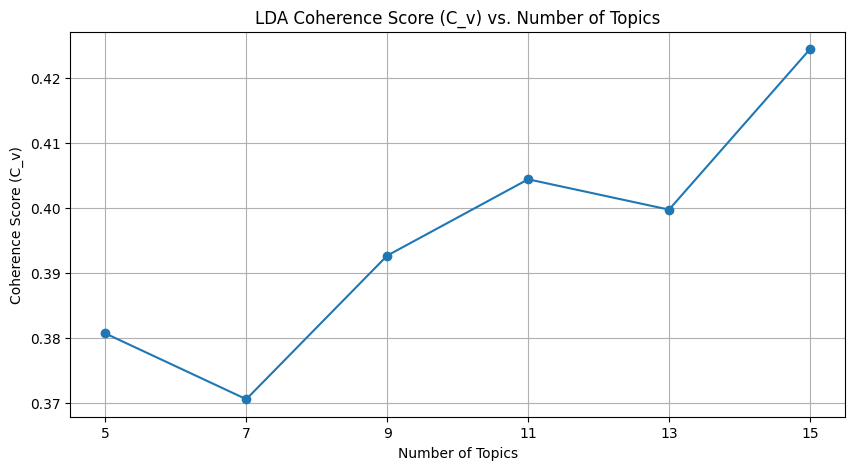


Jumlah topik optimal berdasarkan C_v: 15 (Coherence: 0.4244)


In [14]:
# --- Jalankan Perhitungan Koherensi (Sesuaikan range jika perlu) ---
# PERINGATAN: Ini bisa sangat lama (beberapa menit hingga jam tergantung data & hardware)
# Jika terlalu lama, Anda bisa skip bagian ini dan langsung set num_topics_lda secara manual.
COMPUTE_COHERENCE = True # Set ke True untuk menjalankan, False untuk skip
NUM_TOPICS_START = 5
NUM_TOPICS_LIMIT = 16
NUM_TOPICS_STEP = 2
coherence_values_lda = []
num_topics_range_lda = []

if COMPUTE_COHERENCE:
    coherence_values_lda, num_topics_range_lda = compute_coherence_values(
        dictionary=dictionary,
        corpus=corpus_bow, # LDA biasanya pakai BoW
        texts=tokenized_texts,
        start=NUM_TOPICS_START,
        limit=NUM_TOPICS_LIMIT,
        step=NUM_TOPICS_STEP
    )

    # --- Plot Coherence Scores ---
    if coherence_values_lda:
        plt.figure(figsize=(10, 5))
        plt.plot(num_topics_range_lda, coherence_values_lda, marker='o')
        plt.title('LDA Coherence Score (C_v) vs. Number of Topics')
        plt.xlabel("Number of Topics")
        plt.ylabel("Coherence Score (C_v)")
        plt.xticks(num_topics_range_lda)
        plt.grid(True)
        plt.show()

        # Pilih jumlah topik dengan skor koherensi tertinggi
        optimal_lda_topics_index = np.argmax(coherence_values_lda)
        optimal_num_topics_lda = num_topics_range_lda[optimal_lda_topics_index]
        print(f"\nJumlah topik optimal berdasarkan C_v: {optimal_num_topics_lda} (Coherence: {coherence_values_lda[optimal_lda_topics_index]:.4f})")
    else:
        print("\nTidak ada skor koherensi yang dihitung.")
        optimal_num_topics_lda = 5 # Default jika tidak dihitung
        print(f"Menggunakan jumlah topik default: {optimal_num_topics_lda}")
else:
    print("\nPerhitungan Coherence Score dilewati. Menggunakan jumlah topik yang ditentukan manual.")
    # Tentukan jumlah topik secara manual jika tidak menghitung koherensi
    # Nilai ini HARUS disesuaikan berdasarkan pemahaman domain atau hasil eksperimen sebelumnya.
    optimal_num_topics_lda = 5
    print(f"Jumlah topik LDA diatur ke: {optimal_num_topics_lda}")

In [15]:
# --- 4.2. Melatih Model LDA Final ---
print(f"\nMelatih model LDA final dengan {optimal_num_topics_lda} topik...")
start_time = time.time()
# Gunakan parameter yang sama seperti saat tuning (jika dilakukan)
# passes=15 atau 20 mungkin lebih baik untuk hasil akhir
lda_model = LdaModel(corpus=corpus_bow,
                     id2word=dictionary,
                     num_topics=optimal_num_topics_lda,
                     random_state=42,
                     passes=15, # Lebih banyak pass untuk model final
                     alpha='auto',
                     eta='auto',
                     # chunksize=2000, # Default gensim, sesuaikan jika perlu
                     # update_every=1, # Default: update model setelah setiap chunk (online)
                     # eval_every=None # Default: jangan evaluasi perplexity selama training
                    )
end_time = time.time()
print(f"Pelatihan LDA selesai dalam {end_time - start_time:.2f} detik.")


Melatih model LDA final dengan 15 topik...
Pelatihan LDA selesai dalam 233.34 detik.


In [16]:
# --- 4.3. Menampilkan Topik LDA ---
print(f"\n--- Topik LDA (Top {10} kata per topik) ---")
# `num_words`: Jumlah kata kunci yang ditampilkan per topik.
topics_lda = lda_model.print_topics(num_topics=optimal_num_topics_lda, num_words=10)
for topic_num, topic_words in topics_lda:
    print(f"Topik {topic_num}: {topic_words}")


--- Topik LDA (Top 10 kata per topik) ---
Topik 0: 0.030*"like" + 0.028*"good" + 0.022*"would" + 0.019*"time" + 0.017*"really" + 0.014*"much" + 0.013*"even" + 0.012*"love" + 0.012*"could" + 0.012*"better"
Topik 1: 0.028*"history" + 0.025*"world" + 0.021*"god" + 0.019*"american" + 0.017*"war" + 0.015*"view" + 0.012*"english" + 0.012*"mystery" + 0.011*"fiction" + 0.011*"modern"
Topik 2: 0.043*"color" + 0.037*"black" + 0.029*"white" + 0.018*"ball" + 0.016*"red" + 0.013*"green" + 0.013*"match" + 0.011*"regret" + 0.010*"jack" + 0.010*"elsewhere"
Topik 3: 0.052*"camera" + 0.029*"smell" + 0.022*"digital" + 0.019*"shot" + 0.017*"speed" + 0.015*"lens" + 0.015*"gun" + 0.014*"mouse" + 0.014*"hell" + 0.013*"drop"
Topik 4: 0.038*"great" + 0.023*"work" + 0.018*"year" + 0.017*"bought" + 0.015*"well" + 0.011*"old" + 0.011*"two" + 0.011*"back" + 0.011*"used" + 0.011*"would"
Topik 5: 0.026*"toy" + 0.021*"dog" + 0.021*"baby" + 0.021*"car" + 0.018*"hair" + 0.017*"low" + 0.015*"room" + 0.014*"value" + 0.0

In [17]:
# --- 4.4. Evaluasi Kualitas Topik (Coherence Score) ---
print("\nMenghitung Coherence Score (C_v) untuk model LDA final...")
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score (C_v) Model Final LDA: {coherence_lda:.4f}')
# Skor C_v yang baik biasanya > 0.5, tetapi sangat tergantung pada dataset.


Menghitung Coherence Score (C_v) untuk model LDA final...
Coherence Score (C_v) Model Final LDA: 0.4558


In [18]:
# --- 4.5. Visualisasi Topik LDA dengan pyLDAvis ---
print("\nMenyiapkan visualisasi pyLDAvis...")
# PERINGATAN: Ini juga bisa memakan waktu dan memori, terutama untuk data besar.
# Jika error atau terlalu lambat, coba kurangi jumlah data sampel untuk visualisasi.
try:
    vis_data = gensimvis.prepare(lda_model, corpus_bow, dictionary, mds='tsne') # 'tsne' seringkali lebih baik dari 'pca'
    print("Visualisasi siap ditampilkan.")
    # Tampilkan visualisasi di notebook (jika pyLDAvis.enable_notebook() dipanggil di awal)
    # Atau simpan ke file HTML:
    pyLDAvis.save_html(vis_data, 'lda_visualization.html')
    print("Visualisasi disimpan sebagai 'lda_visualization.html'")
    pyLDAvis.display(vis_data) # Baris ini akan menampilkan visualisasi di output sel notebook
except Exception as e:
    print(f"\nError saat membuat visualisasi pyLDAvis: {e}")
    print("Coba jalankan ulang atau periksa instalasi pyLDAvis.")


Menyiapkan visualisasi pyLDAvis...
Visualisasi siap ditampilkan.
Visualisasi disimpan sebagai 'lda_visualization.html'


## LATENT SEMANTIC ANALYSIS (LSA / LSI)

In [19]:
# --- 5.1. Menentukan Jumlah Topik LSA ---
# Tidak ada metrik sepopuler Coherence Score untuk LSA.
# Jumlah topik sering dipilih berdasarkan tujuan (misalnya, reduksi dimensi)
# atau dievaluasi secara ekstrinsik (misalnya, performa klasifikasi).
# Kita akan gunakan jumlah topik yang sama dengan LDA untuk perbandingan, atau pilih nilai lain.
num_topics_lsa = optimal_num_topics_lda # Menggunakan jumlah topik yang sama dengan LDA
# Atau pilih jumlah yang berbeda, misal:
# num_topics_lsa = 100 # LSA kadang bekerja baik dengan dimensi lebih tinggi awal
print(f"Jumlah topik LSA diatur ke: {num_topics_lsa}")

Jumlah topik LSA diatur ke: 15


In [20]:
# --- 5.2. Melatih Model LSA (LSI) ---
# LSA/LSI seringkali lebih baik menggunakan input TF-IDF.
print("\nMelatih model LSA (LSI) menggunakan corpus TF-IDF...")
start_time = time.time()
try:
    lsi_model = LsiModel(corpus=corpus_tfidf, # Gunakan corpus TF-IDF
                         id2word=dictionary,
                         num_topics=num_topics_lsa
                         # decay=1.0, # Default
                         # onepass=False, # Multi-pass SVD bisa lebih akurat tapi lebih lambat/memori intensif
                         # power_iters=2, # Iterasi tambahan untuk SVD acak
                         # extra_samples=100 # Sampel tambahan untuk SVD acak
                        )
    end_time = time.time()
    print(f"Pelatihan LSA (LSI) selesai dalam {end_time - start_time:.2f} detik.")

    # --- 5.3. Menampilkan Topik LSA ---
    print(f"\n--- Topik LSA (Top {10} kata per topik) ---")
    topics_lsa = lsi_model.print_topics(num_topics=num_topics_lsa, num_words=10)
    for topic_num, topic_words in topics_lsa:
        # Bersihkan format output LSI
        cleaned_topic = re.sub(r'-?\d+\.\d+\*?"', '', topic_words).replace(' + ', ', ').strip()
        print(f"Topik {topic_num}: {cleaned_topic}")

except Exception as e:
    print(f"\nError saat melatih model LSI: {e}")
    print("Ini mungkin terjadi pada corpus yang sangat kecil atau sparse. Coba sesuaikan parameter atau periksa data.")


Melatih model LSA (LSI) menggunakan corpus TF-IDF...
Pelatihan LSA (LSI) selesai dalam 11.14 detik.

--- Topik LSA (Top 10 kata per topik) ---
Topik 0: book", movie", read", great", good", like", would", time", really", love"
Topik 1: book", read", movie", album", song", game", music", reading", author", story"
Topik 2: movie", album", song", film", watch", game", story", dvd", seen", work"
Topik 3: game", album", song", music", book", work", band", best", track", listen"
Topik 4: game", album", work", song", play", fun", battery", book", item", quality"
Topik 5: dvd", movie", season", album", love", show", video", series", player", great"
Topik 6: love", dvd", great", money", waste", old", toy", album", year", story"
Topik 7: good", year", great", sound", quality", time", love", old", read", waste"
Topik 8: story", book", film", movie", album", novel", dvd", series", year", great"
Topik 9: album", song", money", waste", toy", story", music", work", great", battery"
Topik 10: battery"

## MENGGUNAKAN FITUR TOPIK UNTUK ANALISIS SENTIMEN (KONSEP)

Topic modeling (LDA/LSA) sendiri tidak secara langsung melakukan klasifikasi sentimen.
Namun, hasil dari topic modeling dapat digunakan sebagai fitur tambahan atau pengganti
untuk model klasifikasi sentimen (seperti Logistic Regression, SVM, dll.).

Caranya adalah dengan merepresentasikan setiap dokumen (ulasan) sebagai distribusi
probabilitas atas topik-topik yang telah ditemukan. Vektor distribusi topik ini
kemudian menjadi fitur input untuk classifier.

In [21]:
# Mendapatkan Distribusi Topik per Dokumen
# Untuk LDA:
print("Mendapatkan distribusi topik LDA untuk setiap dokumen...")
lda_topic_distributions = []
for bow_doc in corpus_bow:
    # get_document_topics mengembalikan list tuple (topic_id, probability)
    doc_topics = lda_model.get_document_topics(bow_doc, minimum_probability=0.0)
    # Ubah menjadi vektor padat (dense vector) sepanjang num_topics
    topic_vector = [0.0] * optimal_num_topics_lda
    for topic_id, prob in doc_topics:
        if topic_id < optimal_num_topics_lda: # Pastikan ID topik valid
             topic_vector[topic_id] = prob
    lda_topic_distributions.append(topic_vector)

# Buat DataFrame dari distribusi topik LDA
lda_features_df = pd.DataFrame(lda_topic_distributions, index=df.index, columns=[f'LDA_Topic_{i}' for i in range(optimal_num_topics_lda)])
print("Contoh fitur LDA (5 baris pertama):")
print(lda_features_df.head())

Mendapatkan distribusi topik LDA untuk setiap dokumen...
Contoh fitur LDA (5 baris pertama):
   LDA_Topic_0  LDA_Topic_1  LDA_Topic_2  LDA_Topic_3  LDA_Topic_4  \
0     0.191039     0.011922     0.008644     0.006604     0.191554   
1     0.332683     0.007355     0.005333     0.070711     0.218840   
2     0.352890     0.031989     0.007108     0.005431     0.087210   
3     0.174921     0.007743     0.022970     0.004290     0.143539   
4     0.323147     0.009639     0.091881     0.005202     0.161632   

   LDA_Topic_5  LDA_Topic_6  LDA_Topic_7  LDA_Topic_8  LDA_Topic_9  \
0     0.015018     0.201300     0.016224     0.014923     0.005762   
1     0.042548     0.021284     0.009988     0.184454     0.036855   
2     0.034523     0.232818     0.013508     0.012167     0.004738   
3     0.027324     0.219672     0.236549     0.044917     0.003742   
4     0.011930     0.085911     0.201152     0.040430     0.004538   

   LDA_Topic_10  LDA_Topic_11  LDA_Topic_12  LDA_Topic_13  LDA_To

In [22]:
# Mendapatkan Distribusi Topik per Dokumen
# Untuk LSA:
print("\nMendapatkan representasi vektor LSA untuk setiap dokumen...")
lsa_vectors = []
# Terapkan model LSI ke corpus TF-IDF
for tfidf_doc in corpus_tfidf:
    # Hasil LSI adalah list tuple (topic_id, weight)
    lsa_vector_sparse = lsi_model[tfidf_doc]
    # Ubah menjadi vektor padat
    topic_vector = [0.0] * num_topics_lsa
    for topic_id, weight in lsa_vector_sparse:
         if topic_id < num_topics_lsa:
             topic_vector[topic_id] = weight
    lsa_vectors.append(topic_vector)

# Buat DataFrame dari vektor LSA
lsa_features_df = pd.DataFrame(lsa_vectors, index=df.index, columns=[f'LSA_Topic_{i}' for i in range(num_topics_lsa)])
print("Contoh fitur LSA (5 baris pertama):")
print(lsa_features_df.head())


Mendapatkan representasi vektor LSA untuk setiap dokumen...
Contoh fitur LSA (5 baris pertama):
   LSA_Topic_0  LSA_Topic_1  LSA_Topic_2  LSA_Topic_3  LSA_Topic_4  \
0     0.143355     0.143924     0.020970    -0.001067    -0.002971   
1     0.161101    -0.130294     0.102542    -0.133990    -0.040874   
2     0.152054     0.148227    -0.003123    -0.025394    -0.017738   
3     0.141766    -0.105381    -0.217939    -0.010108    -0.041791   
4     0.142593    -0.052314    -0.106765    -0.021793    -0.025877   

   LSA_Topic_5  LSA_Topic_6  LSA_Topic_7  LSA_Topic_8  LSA_Topic_9  \
0    -0.009252    -0.023591     0.083011     0.080093     0.049944   
1     0.006775    -0.035985     0.018455     0.012144     0.019813   
2     0.013924     0.043531    -0.009405    -0.007115    -0.006422   
3    -0.068962    -0.044041    -0.036746     0.111224     0.006407   
4    -0.027693    -0.052453     0.015959    -0.019720     0.048718   

   LSA_Topic_10  LSA_Topic_11  LSA_Topic_12  LSA_Topic_13  LS

In [23]:
# --- Menggabungkan Fitur Topik dengan Data Asli ---
# Fitur ini sekarang dapat digabungkan kembali dengan DataFrame asli
df_with_lda_features = pd.concat([df, lda_features_df], axis=1)
print("\nDataFrame dengan fitur LDA:")
print(df_with_lda_features.head())


DataFrame dengan fitur LDA:
   label  \
0      1   
1      1   
2      0   
3      1   
4      1   

                                                                                                                                                                                           lemmatized_text  \
0  use book product herb easy access material give easy follow product product herb life excellent read herbal book product quite library need product need remedythis book run excellent material easy...   
1  cd great example heavy hardcore softer edge not soft band year old many band day trying combine screaming singing thing rather product result guy music pretty melodic despite heaviness addition pr...   
2  not read book yet review sample kindle point sample read book not forward not story author got inspired write book entire sample heck even not get finishi would like really sample book purchase sa...   
3  movie one favorite partly michigan favorite son jeff daniel also crazys

In [24]:
df_with_lsa_features = pd.concat([df, lsa_features_df], axis=1)
print("\nDataFrame dengan fitur LSA:")
print(df_with_lsa_features.head())


DataFrame dengan fitur LSA:
   label  \
0      1   
1      1   
2      0   
3      1   
4      1   

                                                                                                                                                                                           lemmatized_text  \
0  use book product herb easy access material give easy follow product product herb life excellent read herbal book product quite library need product need remedythis book run excellent material easy...   
1  cd great example heavy hardcore softer edge not soft band year old many band day trying combine screaming singing thing rather product result guy music pretty melodic despite heaviness addition pr...   
2  not read book yet review sample kindle point sample read book not forward not story author got inspired write book entire sample heck even not get finishi would like really sample book purchase sa...   
3  movie one favorite partly michigan favorite son jeff daniel also crazys

In [25]:
# --- Simpan Hasil ke CSV (Opsional) ---
df_with_lda_features.to_csv('./data/df_with_lda_features.csv', index=False)
df_with_lsa_features.to_csv('./data/df_with_lsa_features.csv', index=False)

## KESIMPULAN

Notebook ini telah mendemonstrasikan alur kerja untuk menerapkan LDA dan LSA/LSI pada data teks ulasan:
1.  Data dimuat dan dieksplorasi.
2.  Teks diproses dengan tokenisasi dan penghapusan stopwords.
3.  Dictionary, Corpus BoW, dan Corpus TF-IDF dibuat menggunakan Gensim.
4.  Model LDA dilatih, dievaluasi menggunakan Coherence Score (C_v={coherence_lda:.4f}), dan divisualisasikan dengan pyLDAvis. Jumlah topik optimal (berdasarkan C_v atau manual) adalah {optimal_num_topics_lda}.
5.  Model LSA (LSI) dilatih menggunakan input TF-IDF dengan {num_topics_lsa} topik.
6.  Konsep penggunaan distribusi topik LDA/LSA sebagai fitur untuk klasifikasi sentimen dijelaskan, beserta contoh cara mengekstrak fitur tersebut.